# Build community model

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

import copy

%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()

<Solution 0.12 at 0x7fbaf722e1d0>

In [3]:
with open(ecoli_files+'/me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)
with open(ecoli_files+'/me_models/solution.pickle', 'rb') as solution:
    spore = pickle.load(solution)

## Create spore model

### Change IDs (compartment _s)

In [4]:
# Metabolites
new_compartment = 's'
fix = []
for met in tqdm(spore.metabolites):
    if re.search('_[c,e]$',met.id):
        met.id = re.sub('c$',new_compartment,met.id)
    else:
        met.id = met.id+'_'+new_compartment

100%|██████████| 4214/4214 [00:00<00:00, 139734.97it/s]


In [5]:
# Reactions
new_compartment = 's'
fix = []
for r in tqdm(spore.reactions):
        r.id = r.id+'_'+new_compartment

100%|██████████| 6285/6285 [00:00<00:00, 411174.21it/s]


In [6]:
spore.repair()

In [7]:
# Create new growth key for spore
new_growth_key = 'sigma'
for r in tqdm(spore.reactions):
    lb = r.lower_bound
    ub = r.upper_bound
    new_stoichiometry = {m:s for m,s in r.metabolites.items()}
    if hasattr(lb, 'subs'):
        growth_key = list(lb.free_symbols)[0]
        r.lower_bound = lb.subs(growth_key,new_growth_key)
    if hasattr(ub, 'subs'):
        growth_key = list(ub.free_symbols)[0]
        r.upper_bound = ub.subs(growth_key,new_growth_key)
    for m,s in new_stoichiometry.items():
        if hasattr(s, 'subs'):
            growth_key = list(s.free_symbols)[0]
            new_stoichiometry[m] = s.subs(growth_key,new_growth_key)
    r.add_metabolites(new_stoichiometry,combine=False)

100%|██████████| 6285/6285 [00:45<00:00, 137.24it/s]


In [8]:
# Eliminate exchange reactions:
reactions = [r for r in spore.reactions]
for r in tqdm(reactions):
    if re.search('^EX_',r.id):
        r.remove_from_model()

100%|██████████| 6285/6285 [00:01<00:00, 5749.80it/s]


### Create spore biomass reactions

In [9]:
bio_rxn = spore.reactions.BIOMASS_BS_10_FWD_CPLX_dummy_s

In [10]:
bio_comp = pd.read_csv('spore_composition.csv',index_col=0)

In [11]:
# Identify lipid metabolites in biomass equation
lipid_demand = {}
for m in bio_comp.index:
    if '_BS_c' in m:
        new_id = re.sub('c$','s',m)
        value = bio_comp.loc[m]['coeff']
        lipid_demand[new_id] = abs(value)
                
for met, requirement in lipid_demand.items():
    component_mass = spore.metabolites.get_by_id(met).formula_weight / 1000.
    rxn = cobrame.SummaryVariable('Demand_' + met)
    spore.add_reactions([rxn])
    rxn.add_metabolites({met: -1 * requirement,
                         'lipid_biomass_s': component_mass * requirement})
    rxn.lower_bound = spore.reactions.biomass_dilution_s.lower_bound
    rxn.upper_bound = 1000.
    print(rxn.reaction)

2.353230994969913e-06 cdlp_BS_s <=> 0.0003138918345705195 lipid_biomass_s
5.5911661649980173e-05 d12dg_BS_s <=> 0.004943796394485683 lipid_biomass_s
1.1181601688200874e-05 lysylpgly_BS_s <=> 0.0009416755037115587 lipid_biomass_s
4.347080715231638e-05 m12dg_BS_s <=> 0.0031389183457051955 lipid_biomass_s
8.915068976475303e-05 pgly_BS_s <=> 0.006356309650053021 lipid_biomass_s
0.00028364101108229784 psetha_BS_s <=> 0.01934358430540827 lipid_biomass_s
3.337340219543245e-05 t12dg_BS_s <=> 0.0034920466595970297 lipid_biomass_s
0.0012215982898295598 gtca3_45_BS_s <=> 0.01794281096319678 lipid_biomass_s
4.701037948766861e-06 lipo1_24_BS_s <=> 0.00397181389778114 lipid_biomass_s
0.0020899471566517814 tcam_BS_s <=> 0.02898675371802525 lipid_biomass_s


### Merge

In [12]:
with open(ecoli_files+'/me_models/solution.pickle', 'rb') as solution:
    sporeme = pickle.load(solution)

In [13]:
# Mother is not growing. Reactions should then be associated to sigma
new_growth_key = 'sigma'
for r in tqdm(sporeme.reactions):
    lb = r.lower_bound
    ub = r.upper_bound
    new_stoichiometry = {m:s for m,s in r.metabolites.items()}
    if hasattr(lb, 'subs'):
        growth_key = list(lb.free_symbols)[0]
        r.lower_bound = float(lb.subs(growth_key,0.))
    if hasattr(ub, 'subs'):
        growth_key = list(ub.free_symbols)[0]
        r.upper_bound = float(ub.subs(growth_key,1000.))
    for m,s in new_stoichiometry.items():
        if hasattr(s, 'subs'):
            growth_key = list(s.free_symbols)[0]
            new_stoichiometry[m] = s.subs(growth_key,new_growth_key)
            a = 1
    r.add_metabolites(new_stoichiometry,combine=False)

100%|██████████| 6285/6285 [00:47<00:00, 133.37it/s]


In [14]:
sporeme.add_reactions(spore.reactions)

In [15]:
# Connect C with S
## Change spore transport from e-s to c-s
for m in tqdm(sporeme.metabolites):
    if not isinstance(m,cobrame.Metabolite) or not re.search('_s$',m.id):
        continue
    in_transport = get_transport_reactions(sporeme,m.id,comps=['e','s'])
    out_transport = get_transport_reactions(sporeme,m.id,comps=['s','e'])
    transport_reactions = in_transport + out_transport
    for r in transport_reactions:
        old_met = sporeme.metabolites.get_by_id(re.sub('_s$','_e',m.id))
        new_met = sporeme.metabolites.get_by_id(re.sub('_s$','_c',m.id))
        coeff = r.metabolites[old_met]
        r.add_metabolites({old_met:-coeff,new_met:coeff})

100%|██████████| 8187/8187 [00:02<00:00, 2866.99it/s] 


In [16]:
sporeme.objective = 'biomass_dilution_s'
sporeme.reactions.get_by_id('BIOMASS_BS_10_FWD_CPLX_dummy_s').upper_bound = 0

### Manual fixes

As reported by Eammon, arginine is transported through permeases RocC and RocE, and ABC transporters ArtPQR.

In [17]:
# close_met_transport = ['3gmp_c','gmp_c']
# transporters = []
# for m in tqdm(close_met_transport):
#     transport = get_transport_reactions(sporeme,m,comps=['c','s']) + \
#         get_transport_reactions(sporeme,m,comps=['s','c'])
#     [transporters.append(i) for i in transport]
# transporters

In [18]:
# for t in transporters:
#     t.lower_bound = 0
#     t.upper_bound = 0

### Close specific reactions in the spore
It was shown that all but one (odhB) TCA reaction was necessary. We close the unnecessary ones.

In [6]:
gene_dictionary = pd.read_csv('../../building_data/gene_name_dictionary.csv',index_col=1)
eliminate_genes = ['citA','citB','citZ','icd','sucD','fumC','mdh']
gene_dictionary.loc[eliminate_genes]['locus_id']

name
citA    BSU09440
citB    BSU18000
citZ    BSU29140
icd     BSU29130
sucD    BSU16100
fumC    BSU33040
mdh     BSU29120
Name: locus_id, dtype: object

In [7]:
eliminate_ids = gene_dictionary.loc[eliminate_genes]['locus_id'].tolist()

In [8]:
essentiality_df = pd.read_csv('../essentiality/essentiality_results.csv',index_col=0)
essentiality_df.loc[eliminate_ids]

,response_me,essentiality_me,response_m,essentiality_m,true_essentiality
BSU09440,0.000000,0,0.000000,0,0
BSU18000,-0.153926,-,-0.152083,-,0
BSU29140,-0.000028,0,0.000000,0,0
BSU29130,-0.153936,-,-0.152083,-,0
BSU16100,-0.061582,-,-0.059546,-,0
BSU33040,-0.139421,-,-0.135523,-,0
BSU29120,-0.065595,-,-0.063391,-,0


In [11]:
essentiality_df.loc[eliminate_ids][['response_me','essentiality_me','true_essentiality']]

,response_me,essentiality_me,true_essentiality
BSU09440,0.000000,0,0
BSU18000,-0.153926,-,0
BSU29140,-0.000028,0,0
BSU29130,-0.153936,-,0
BSU16100,-0.061582,-,0
BSU33040,-0.139421,-,0
BSU29120,-0.065595,-,0


In [9]:
for gene in eliminate_ids:
    r = 'translation_' + gene +'_s'
    print(r)
    rxn = sporeme.reactions.get_by_id(r)
    rxn.upper_bound = 0
    rxn.lower_bound = 0

translation_BSU09440_s


NameError: name 'sporeme' is not defined

### Solve

In [23]:
solve_me_model(sporeme, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6,growth_key = 'sigma')

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 424.082317 seconds
Finished substituting S,lb,ub in 17.994887 seconds
Finished makeME_LP in 2.066244 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 18.102022 seconds
Finished makeME_LP in 2.058146 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 17.925951 seconds
Finished makeME_LP in 2.065915 seconds
Getting MINOS parameters from ME_NLP...
3 0.0625 0.0625 0.125 0.0625 optimal
Finished substituting S,lb,ub in 19.659141 seconds
Finished makeME_LP in 2.158814 seconds
Getting MINOS parameters from ME_NLP...
4 0.09375 0.09375 0.125 0.09375 optimal
Finished substituting S,lb,ub in 18.598482 seconds
Finished makeME_LP in 2.181318 seconds
Getting MINOS parameters from ME_NLP...
5 0.109375 0.109375 0.125 0.109375 optimal
Finished substituting S,lb,ub in 18.500516 seconds
Finished makeME_LP in 2.073452 sec

In [24]:
with open("./sporeme_solution.pickle", "wb") as outfile:
    pickle.dump(sporeme, outfile)

In [25]:
with open("./sporeme_solution.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [26]:
get_reactions_of_met(sporeme,'malcoa_c',only_types=['MetabolicReaction'])

( formation_CPLX000-8_s 0.0 1000.0 ) 	 protein_BSU28730_s + protein_BSU28740_s + protein_BSU28750_s --> CPLX000-8_s
( ARBabc_FWD_CPLX000-8_s 0 999999.0 ) 	 arab__L_c + atp_s + h2o_s <=> -4.27350427350427e-6*sigma CPLX000-8_s + adp_s + arab__L_s + h_s + pi_s


[<ComplexFormation formation_CPLX000-8_s at 0x7f21140ac518>,
 <MetabolicReaction ARBabc_FWD_CPLX000-8_s at 0x7f2113eb2160>]

FileNotFoundError: [Errno 2] No such file or directory: './analysis/{}_breakdown.svg'

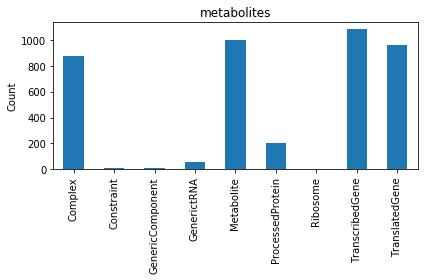

In [52]:
import matplotlib.pyplot as plt
fields = ['metabolites','reactions']
for idx,f in enumerate(fields):
    get_breakdown(me,f).plot.bar(legend=False)
    plt.ylabel('Count')
    plt.title(f)
    plt.tight_layout()
    plt.savefig("./analysis/{}_breakdown.svg", format="SVG")